# Import packages

In [ ]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr, spearmanr
from hdbscan import HDBSCAN

# Functions for contour regression

In [6]:
def project_contour_curvature(data, curvature_values, smoothed_contour_coords):
    projected_curv_list = []
    avg_distance_to_gland_list = []

    for cell in data:
        cell_coords = cell.obs[['X', 'Y']].values[0]

        distances = np.linalg.norm(smoothed_contour_coords - cell_coords, axis=1)
        closest_k_indexes = np.argsort(distances)[:5]

        projected_curv = np.mean(curvature_values[closest_k_indexes])
        projected_curv_list.append(projected_curv)

        avg_distance_to_gland = np.mean(distances[closest_k_indexes])
        avg_distance_to_gland_list.append(avg_distance_to_gland)

    data.obs['projected_curvature'] = projected_curv_list
    data.obs['distance_to_gland'] = avg_distance_to_gland_list

In [7]:
def in_contour(data, contour_coords):
    cell_coords = data.obs[['X', 'Y']].values
    
    in_countour_bool_list = [] #Contains booleans whether cell is in contour or not
    contour_coords = np.asarray(contour_coords, dtype=np.float32)  # ensure numeric
    contour_coords = contour_coords.reshape((-1, 1, 2)) 
    for cell_coord in cell_coords:

        result = cv2.pointPolygonTest(contour_coords, cell_coord, False)
        if result > 0:
            # print(f"Point {point} is inside the contour.")
            in_countour_bool_list.append(True)
        elif result == 0:
            # print(f"Point {point} is on the contour.")
            in_countour_bool_list.append(True)
        else:
            # print(f"Point {point} is outside the contour.")
            in_countour_bool_list.append(False)

    data.obs['In_gland?'] = pd.Categorical(in_countour_bool_list)

In [8]:
def get_cells_in_and_around_contour(contour_coordinates, data, buffer=200):

    # Extract x and y coordinates from the gland contour
    x_coords = [point[1] for point in contour_coordinates]
    y_coords = [point[0] for point in contour_coordinates]

    # Determine the bounding box of the gland contour with buffer
    min_x, max_x = min(x_coords) - buffer, max(x_coords) + buffer
    min_y, max_y = min(y_coords) - buffer, max(y_coords) + buffer

    # Filter cells within the bounding box
    cells_in_area = data.obs[
        (data.obs['Y'] >= min_x) & (data.obs['Y'] <= max_x) &
        (data.obs['X'] >= min_y) & (data.obs['X'] <= max_y) 
    ]

    # print(cells_in_area)

    # # Plot the gland contour and the filtered points
    # plt.figure(figsize=(10, 8))
    # plt.plot(x_coords, y_coords, color='red', linewidth=2, label='Gland Contour')
    # plt.scatter(cells_in_area['X'], cells_in_area['Y'], s=10, color='blue', label='Filtered Points')
    # plt.gca().invert_yaxis()
    # plt.xlabel('X Coordinate')
    # plt.ylabel('Y Coordinate')
    # plt.title(f'Gland Contour and Filtered Points for Patient {patient_id}, Gland {gland_number}')
    # plt.legend()
    # plt.show()

    return cells_in_area.index.to_list()

## format data to compute projections and linear regression

In [ ]:
def get_anndata(
    contour_coordinates,
    data,
    curvature_profile,
    buffer=200,
    sigma=2,
    curvature_clip=(2.5, 99)
):

    # Select cells in and around the contour
    cells_in_gland_crop = get_cells_in_and_around_contour(
        contour_coordinates=contour_coordinates,
        data=data,
        buffer=buffer
    )

    # Create AnnData object
    gland_data = sc.AnnData(
        data.to_df().loc[cells_in_gland_crop].copy()
    )

    # Log-normalize
    sc.pp.log1p(gland_data)

    # Store spatial coordinates (X, Y)
    gland_data.obs[['X', 'Y']] = (
        data.obs.loc[cells_in_gland_crop][['Y', 'X']].values
    )

    # Smooth contour coordinates
    smoothed_x = gaussian_filter1d(
        contour_coordinates[:, 0], sigma=sigma, mode='wrap'
    )
    smoothed_y = gaussian_filter1d(
        contour_coordinates[:, 1], sigma=sigma, mode='wrap'
    )

    smoothed_contour_coords = np.column_stack([smoothed_y, smoothed_x])

    # Determine whether cells are inside the contour
    in_contour(gland_data, smoothed_contour_coords)

    # Clip curvature values to reduce outliers
    lower, upper = np.percentile(curvature_profile, curvature_clip)
    curvature_profile = np.clip(curvature_profile, lower, upper)

    # Project curvature onto cells
    project_contour_curvature(
        gland_data,
        curvature_profile,
        smoothed_contour_coords
    )

    # Store results
    gland_data.uns['smoothed_curvature_coords'] = smoothed_contour_coords
    gland_data.uns['curvature_values'] = curvature_profile

    return gland_data


## Import data and curvature 

In [13]:
cell_data = sc.read_h5ad(r"C:\Users\ikordic3\Desktop\Github data and notebooks\adata.h5ad")
contour_coordinates = np.load(r"C:\Users\ikordic3\Desktop\Github data and notebooks\contour_coords.npy")
curvature_profile = np.load(r"C:\Users\ikordic3\Desktop\Github data and notebooks\curvature_values.npy")

In [35]:
%matplotlib inline
patient_id = 'PF13'
gland_number = 0# Replace with the desired gland number if applicable

# Get the gland contour coordinates
# gland_contour_coords = np.array(contour_coordinates[patient_id][gland_number][0])

# Call the get_anndata function
gland_data = get_anndata(contour_coordinates,
                        cell_data,
                        curvature_profile)

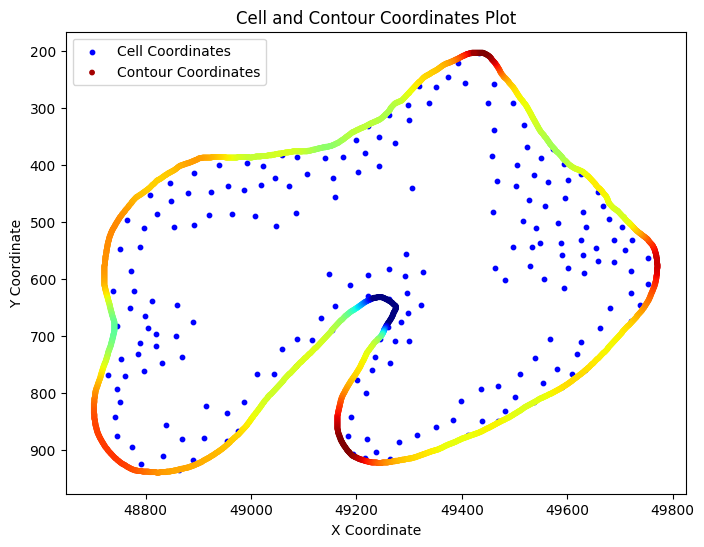

In [36]:
# Extract cell coordinates from gland_data
cell_coords = gland_data.obs[['X', 'Y']].values

# Extract contour coordinates from gland_data
curv_coords = gland_data.uns['smoothed_curvature_coords']
curv_values = gland_data.uns['curvature_values']

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(cell_coords[:, 1], cell_coords[:, 0], c='blue', s=10, label='Cell Coordinates')
plt.scatter(curv_coords[:, 1], curv_coords[:, 0], c=curv_values, s=10, cmap='jet', label='Contour Coordinates')
plt.gca().invert_yaxis()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Cell and Contour Coordinates Plot')
plt.legend()
plt.show()

## compute and plot curvature/gene correlation

In [37]:
def microniches_in_gland_v4(data, gene, plot = False):
    # This version looks cells that have curvature higher than 0 then uses DBSAN to cluster 
    # regions where curvature is high -> that way curved areas are not cut in the middle
    data = data[data.obs['In_gland?'] == True]
    cell_coords = data.obs[['X','Y']].values
    gene_expression = data.to_df()[gene].values
    projected_curvature = data.obs['projected_curvature'].values
    mean_gene_expression_in_gland = gene_expression.mean()

    cell_idx_positive_curvature = np.argwhere(projected_curvature > np.mean(projected_curvature)).flatten()
    cell_idx_negative_curvature = np.argwhere(projected_curvature < np.mean(projected_curvature)).flatten()

    postive_cell_coords = cell_coords[cell_idx_positive_curvature]
    negative_cell_coords = cell_coords[cell_idx_negative_curvature]

    # Compute average distance between cells

    clusterer = HDBSCAN(min_samples=None, min_cluster_size=5)
    cluster_labels = clusterer.fit_predict(postive_cell_coords)
    Pos_labels = ['Pos_' + str(label) for label in cluster_labels]


    positive_data = sc.AnnData()
    positive_data.obs[['X', 'Y']] = postive_cell_coords
    positive_data.obs['labels'] = pd.Categorical(Pos_labels)
    positive_data.obs['projected_curvature'] = projected_curvature[cell_idx_positive_curvature]
    positive_data.obs['gene_expression'] = gene_expression[cell_idx_positive_curvature]
    positive_data = positive_data[~(positive_data.obs['labels'] == 'Pos_-1')]


    clusterer = HDBSCAN(min_samples=None, min_cluster_size=5)
    cluster_labels = clusterer.fit_predict(negative_cell_coords)
    Neg_labels = ['Neg_' + str(label) for label in cluster_labels]

    negative_data = sc.AnnData()
    negative_data.obs[['X', 'Y']] = negative_cell_coords
    negative_data.obs['labels'] = pd.Categorical(Neg_labels)
    negative_data.obs['projected_curvature'] = projected_curvature[cell_idx_negative_curvature]
    negative_data.obs['gene_expression'] = gene_expression[cell_idx_negative_curvature]
    negative_data = negative_data[~(negative_data.obs['labels'] == 'Neg_-1')]

    concat_data = sc.concat([positive_data, negative_data])

    postive_group_df = positive_data.obs.groupby('labels')
    negative_group_df = negative_data.obs.groupby('labels')


    positive_group_data = sc.AnnData()
    positive_group_data.obs['gene_expression'] = postive_group_df['gene_expression'].mean()
    positive_group_data.obs['projected_curvature'] = postive_group_df['projected_curvature'].mean()
    positive_group_data.obs['labels'] = pd.Categorical(postive_group_df['gene_expression'].mean().index.to_list())

    negative_group_data = sc.AnnData()
    negative_group_data.obs['gene_expression'] = negative_group_df['gene_expression'].mean()
    negative_group_data.obs['projected_curvature'] = negative_group_df['projected_curvature'].mean()
    negative_group_data.obs['labels'] = pd.Categorical(negative_group_df['gene_expression'].mean().index.to_list())

    concat_group_data = sc.concat([positive_group_data, negative_group_data])

    # Get x and y data
    x = concat_group_data.obs['projected_curvature'].values
    y = concat_group_data.obs['gene_expression'].values

    # Compute linear fit (slope and intercept)
    slope, intercept = np.polyfit(x, y, 1)

    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = slope * x_vals + intercept

    # Compute R-squared value
    y_pred = slope * x + intercept
    ss_total = np.sum((y - np.mean(y))**2)
    ss_residual = np.sum((y - y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)

    # Generate regression line
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = slope * x_vals + intercept

    pearson_corr, _ = pearsonr(x.flatten(), y.flatten())
    spearman_corr,_ = spearmanr(x.flatten(), y.flatten())

        # Print equation, R² value, and Pearson correlation
    equation = f"y = {slope:.2f}x + {intercept:.2f}"
    r2_text = f"R² = {r_squared:.3f}"
    pearson_text = f"Pearson r = {pearson_corr:.3f}"
    spearman_text = f"Spearman r = {spearman_corr:.3f}"

    if plot == True:
        #     Plot negative and postive cells
        fig1, ax1 = plt.subplots(1,2)

        ax1[0].scatter(postive_cell_coords[:,1], postive_cell_coords[:,0])
        ax1[0].invert_yaxis()
        ax1[0].axis('equal')
        ax1[0].set_xlabel('')
        ax1[0].set_xticks([])
        ax1[0].set_ylabel('')
        ax1[0].set_yticks([])

        ax1[1].scatter(negative_cell_coords[:,1], negative_cell_coords[:,0])
        ax1[1].invert_yaxis()
        ax1[1].axis('equal')
        ax1[1].set_xlabel('')
        ax1[1].set_xticks([])
        ax1[1].set_ylabel('')
        ax1[1].set_yticks([])

        fig2, ax2 = plt.subplots(1,2, figsize=(6.4,4.8))
        sc.pl.scatter(concat_data, x='Y', y='X', color='labels',size=500, ax=ax2[1], show=False)
        # ax.set_title(f'{list(gene_clusters)}')
        ax2[1].spines[['top', 'right', 'left', 'bottom']].set_visible(False)
        ax2[1].set_xlabel('')
        ax2[1].set_xticks([])
        ax2[1].set_ylabel('')
        ax2[1].set_yticks([])
        ax2[1].invert_yaxis()
        ax2[1].axis('equal')

        # add curvature to the plot
        curv_coords = gland_data.uns['smoothed_curvature_coords']
        ax2[1].scatter(x = curv_coords[:,1],
                        y = curv_coords[:,0],
                        s = 5,
                        c = 'k')


        ax2[1].set_title('Microniches')

        plot = ax2[0].scatter(x = concat_data.obs['Y'],
                    y = concat_data.obs['X'],
                    c = concat_data.obs['gene_expression'],
                    cmap = 'coolwarm',
                    s= 100)
        
        cbar = fig2.colorbar(plot, ax=ax2[0])
        ax2[0].spines[['top', 'right', 'left', 'bottom']].set_visible(False)
        ax2[0].axis('equal')
        ax2[0].set_xlabel('')
        ax2[0].set_xticks([])
        ax2[0].set_ylabel('')
        ax2[0].set_yticks([])
        ax2[0].invert_yaxis()

        ax2[0].set_title(f'Cluster Expression')

        plt.subplots_adjust(wspace=0.5)  # Add space between the two subplots
        # ax.set_title(f'{list(gene_clusters)} expression')

        fig4, ax4 = plt.subplots()
        sc.pl.scatter(concat_group_data, x='projected_curvature', y='gene_expression', color='labels',size = 2000,  legend_fontsize=15, ax=ax4, show=False)
        # ax.set_title(f'{gene_clusters}')
        ax4.set_title('Scatter plot of gene clusters')
        ax4.set_xlabel('Projected curvature')
        ax4.set_ylabel('Gene expression')
        ax4.spines[['top', 'right']].set_visible(False)

        # Plot regression line
        ax4.plot(x_vals, y_vals, color='r', linestyle='dashed', linewidth=5, 
                label=f'Fit: y={slope:.2f}x+{intercept:.2f}')

        # Add R² and Pearson r to the plot
        text_x = x.min() + (x.max() - x.min()) * 1.1  # Position at 5% from min x
        text_y = y.max() - (y.max() - y.min()) * 1.3  # Position at 10% from max y
        ax4.text(text_x, text_y, f"{r2_text}\n{pearson_text}\n{spearman_text}", fontsize=18, color='black', 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

        return fig2, fig4
    
    # else:
    #     return pearson_corr, spearman_corr, mean_gene_expression_in_gland

    if plot == False:
        return pearson_corr, spearman_corr, mean_gene_expression_in_gland

# Plot Correlation

c:\Users\ikordic3\AppData\Local\anaconda3\envs\Work\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
c:\Users\ikordic3\AppData\Local\anaconda3\envs\Work\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\ikordic3\AppData\Local\Temp\ipykernel_137096\2007826602.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  postive_group_df = positive_data.obs.groupby('labels')
C:\Users\ikordic3\AppData\Local\Temp\ipykernel_137096\2007826602.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a f

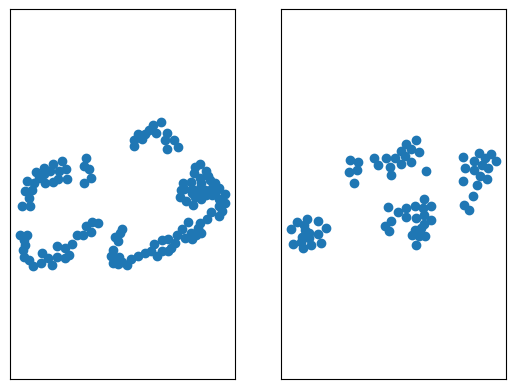

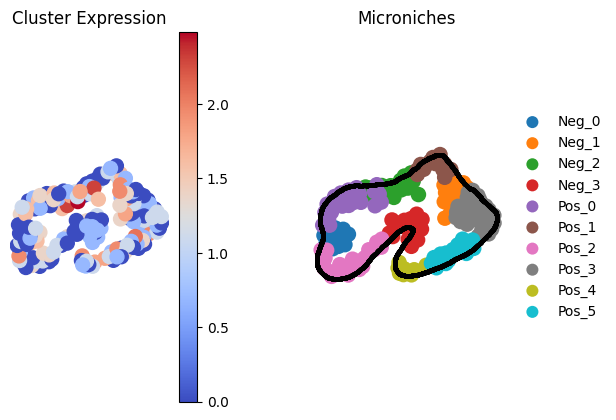

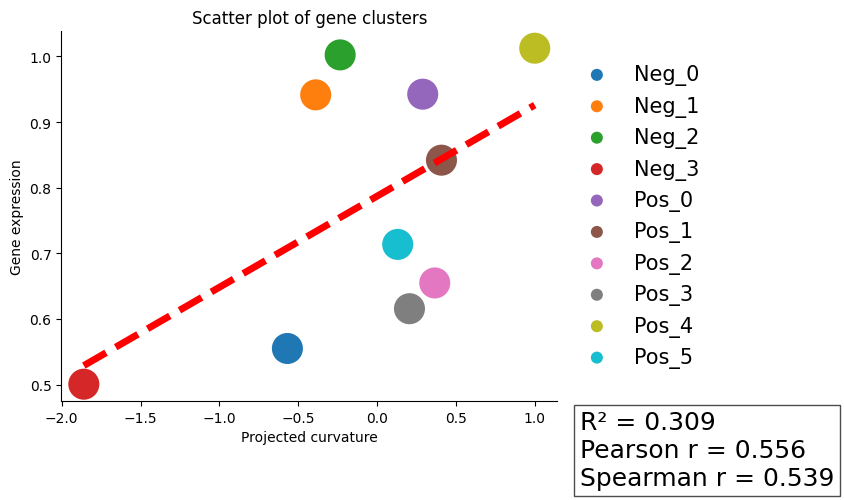

In [38]:
# Specify the gene to test
gene = 'FOXA1'  # Replace with the desired gene column name

# Call the function with the gland data and the specified gene
fig2, fig4 = microniches_in_gland_v4(gland_data, gene, plot=True)